In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
# File to Load (Remember to Change These)
file_to_load = "/Users/asun/Desktop/Team3-Project1/311_Service_Requests.csv"


# Read 311 Service Requestes File and store into Pandas data frame
df = pd.read_csv(file_to_load,encoding="ISO-8859-1")
print(len(df))




/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9,10,11,12,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


751169


In [2]:
df.head()


,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,OWNER_DEPARTMENT,STATUS,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,STREET_ADDRESS,CITY,...,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,Boundaries - ZIP Codes,Community Areas,Zip Codes,Census Tracts,Wards
0,SR18-00019409,Tree Trim Request,SEF,Streets and Sanitation,Open,12/03/2018 08:49:35 AM,03/07/2019 10:31:25 PM,NaN,3824 W 106TH ST,CHICAGO,...,1.152605e+06,1.834123e+06,41.700690,-87.716844,"(41.700689971688, -87.71684413037)",33.0,73.0,4447.0,316.0,42.0
1,SR18-00019450,Tree Removal Request,SEE,Streets and Sanitation,Open,12/03/2018 09:12:29 AM,03/07/2019 10:33:14 PM,NaN,2916 N NEW ENGLAND AVE,CHICAGO,...,1.129842e+06,1.918706e+06,41.933218,-87.798265,"(41.933217894637, -87.79826490538)",52.0,18.0,22254.0,397.0,44.0
2,SR18-00019454,Tree Removal Request,SEE,Streets and Sanitation,Open,12/03/2018 09:14:30 AM,03/07/2019 10:33:14 PM,NaN,471 W 31ST ST,CHICAGO,...,1.173497e+06,1.884364e+06,41.838122,-87.638859,"(41.838121890605, -87.638858915303)",40.0,58.0,21194.0,223.0,48.0
3,SR18-00019481,Tree Removal Request,SEE,Streets and Sanitation,Open,12/03/2018 09:36:11 AM,03/07/2019 10:48:39 PM,NaN,3638 W 59TH PL,CHICAGO,...,1.152960e+06,1.864979e+06,41.785359,-87.714732,"(41.785358643864, -87.714731628488)",58.0,63.0,21867.0,339.0,6.0
4,SR19-00961625,Aircraft Noise Complaint,AVN,Aviation,Completed,02/05/2019 10:05:07 AM,02/10/2019 02:00:25 PM,02/05/2019 10:05:08 AM,33W801 N MARE BARN LN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# cleaning up data

#retrive Remove Abandoned Vehicle Requests from Other Requests
car_df=df.loc[df["SR_TYPE"]=="Abandoned Vehicle Complaint", :]


car_done_df = car_df.loc[car_df['STATUS']=='Completed']


# Create a dataframe from select columns
car_summary_df=car_done_df.loc[:,["SR_NUMBER", "CREATED_DATE", "CLOSED_DATE", "STATUS", "SR_TYPE", "Zip Codes", "Wards"]]

# Remove NA rows in Ward
#car_summary_df=car_summary_df.dropna(subset = ["Wards"], inplace=True)


# Remove "0" ward rows
car_summary_df=car_summary_df.loc[car_summary_df['Wards']!=0,["SR_NUMBER", "CREATED_DATE", "CLOSED_DATE", "STATUS", "SR_TYPE", "Zip Codes", "Wards"]]
car_summary_df=car_summary_df.reset_index(drop=True)



#convert string to datetime type
car_summary_df['CREATED_DATE']=car_summary_df['CREATED_DATE'].astype('datetime64[ns]')
car_summary_df['CLOSED_DATE']=car_summary_df['CLOSED_DATE'].astype('datetime64[ns]')

days=(car_summary_df['CLOSED_DATE'] - car_summary_df['CREATED_DATE']).dt.days

car_summary_df['Days_Completion']=days
car_summary_df.head()


,SR_NUMBER,CREATED_DATE,CLOSED_DATE,STATUS,SR_TYPE,Zip Codes,Wards,Days_Completion
0,SR19-00998650,2019-02-12 05:13:45,2019-02-28 07:00:59,Completed,Abandoned Vehicle Complaint,21184.0,46.0,16
1,SR19-01004254,2019-02-13 07:39:05,2019-02-28 07:07:15,Completed,Abandoned Vehicle Complaint,21867.0,8.0,14
2,SR19-01004261,2019-02-13 07:40:24,2019-02-28 07:09:09,Completed,Abandoned Vehicle Complaint,21867.0,8.0,14
3,SR19-01018598,2019-02-15 12:03:21,2019-02-28 06:56:38,Completed,Abandoned Vehicle Complaint,21861.0,22.0,12
4,SR19-01055155,2019-02-22 13:09:47,2019-02-28 07:07:23,Completed,Abandoned Vehicle Complaint,22212.0,22.0,5


In [4]:
car_summary_df["Days_Completion"].describe()



count    18242.000000
mean        17.498575
std         17.174938
min          0.000000
25%          2.000000
50%         12.500000
75%         31.000000
max        121.000000
Name: Days_Completion, dtype: float64

In [5]:
# doing some stats for abandoned vehicle complaint requests
same_day=car_summary_df.loc[car_summary_df["Days_Completion"]==0]
same_day_total=same_day["Days_Completion"].count()
total_completed_requests = car_summary_df["Days_Completion"].count()
#print(total_completed_requests)
same_day_percent=round(same_day_total/total_completed_requests*100,2)
#print(same_day_percent)

start_date = car_summary_df["CREATED_DATE"].min()
end_date = car_summary_df["CREATED_DATE"].max()

print(f'Between {start_date} and {end_date}:')
print(f'Total number of completed removed abandoned vehicle requests: {total_completed_requests}.')
print(f'Number of requests completed on the same day: {same_day_total}')
print(f'Percent of removed abandoned vehicle requests completed on the same day: {same_day_percent}%')


Between 2018-07-01 07:03:15 and 2019-03-22 07:51:14:
Total number of completed removed abandoned vehicle requests: 18242.
Number of requests completed on the same day: 2907
Percent of removed abandoned vehicle requests completed on the same day: 15.94%


In [6]:
car_summary_df.head()

,SR_NUMBER,CREATED_DATE,CLOSED_DATE,STATUS,SR_TYPE,Zip Codes,Wards,Days_Completion
0,SR19-00998650,2019-02-12 05:13:45,2019-02-28 07:00:59,Completed,Abandoned Vehicle Complaint,21184.0,46.0,16
1,SR19-01004254,2019-02-13 07:39:05,2019-02-28 07:07:15,Completed,Abandoned Vehicle Complaint,21867.0,8.0,14
2,SR19-01004261,2019-02-13 07:40:24,2019-02-28 07:09:09,Completed,Abandoned Vehicle Complaint,21867.0,8.0,14
3,SR19-01018598,2019-02-15 12:03:21,2019-02-28 06:56:38,Completed,Abandoned Vehicle Complaint,21861.0,22.0,12
4,SR19-01055155,2019-02-22 13:09:47,2019-02-28 07:07:23,Completed,Abandoned Vehicle Complaint,22212.0,22.0,5


Text(0, 0.5, 'Total Completed Number of Vehicle Remove Requests')

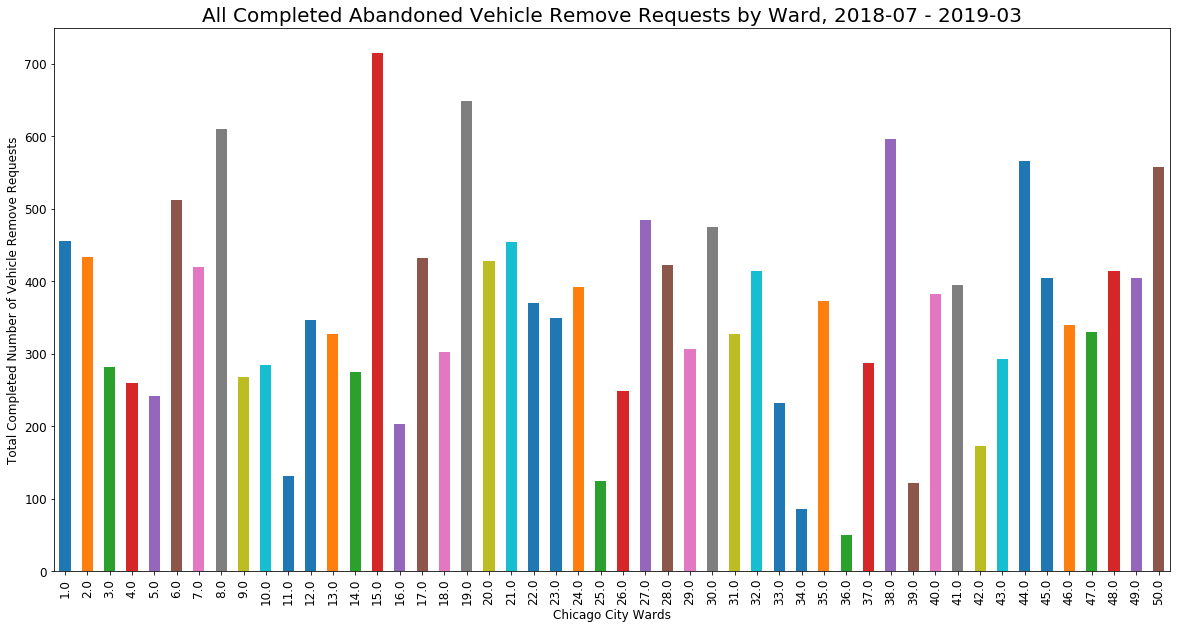

In [16]:
# Plot total completed number of requests by ward
# Group by ward
completed_group = car_summary_df.groupby("Wards")

# Count the number of requests by ward
ward_counts = completed_group["Wards"].count()

# Plot in a bar chart
ward_chart = ward_counts.plot(kind='bar', figsize = (20,10), fontsize=12)

# Set the xlabel and ylabel using class methods
ward_chart.set_title("All Completed Abandoned Vehicle Remove Requests by Ward, 2018-07 - 2019-03", fontsize=20)
ward_chart.set_xlabel("Chicago City Wards", fontsize=12)
ward_chart.set_ylabel("Total Completed Number of Vehicle Remove Requests", fontsize=12)





Text(0, 0.5, 'Total uncompleted Number of Vehicle Remove Requests')

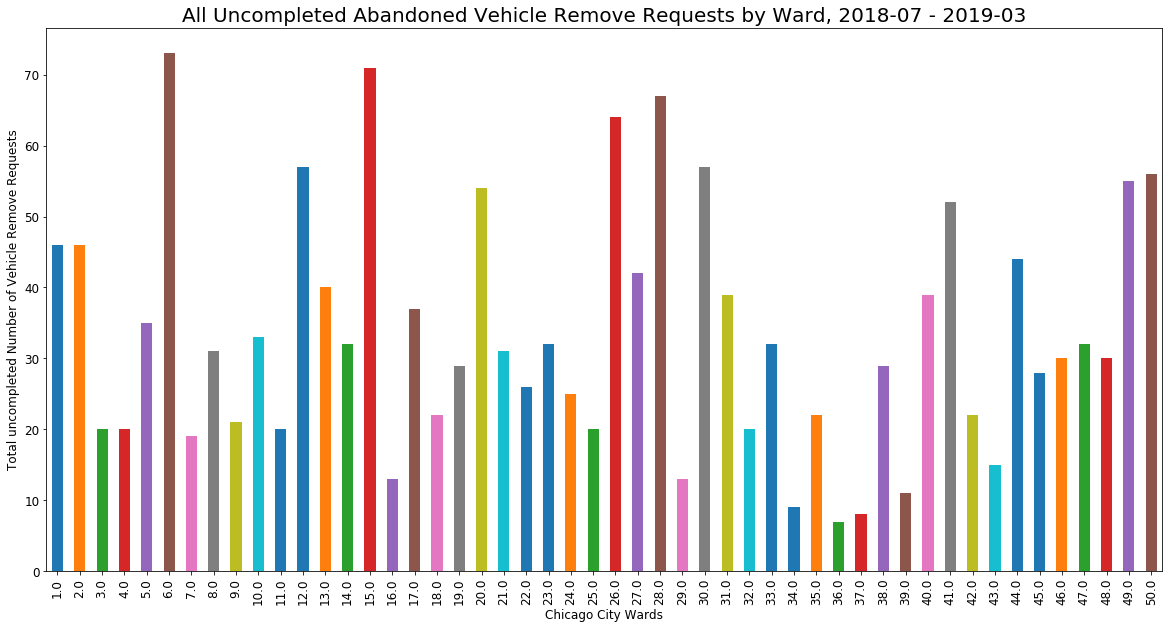

In [19]:
# Plot total uncompletd number of requests by ward
# Group by ward
uncompleted_group = car_df.loc[car_df['STATUS']=='Open']
uncompleted_group=uncompleted_group.groupby("Wards")

# Count the number of requests by ward
ward_counts_un = uncompleted_group["Wards"].count()

# Plot in a bar chart
ward_chart_un = ward_counts_un.plot(kind='bar', figsize = (20,10), fontsize=12)

# Set the xlabel and ylabel using class methods
ward_chart_un.set_title("All Uncompleted Abandoned Vehicle Remove Requests by Ward, 2018-07 - 2019-03", fontsize=20)
ward_chart_un.set_xlabel("Chicago City Wards", fontsize=12)
ward_chart_un.set_ylabel("Total uncompleted Number of Vehicle Remove Requests", fontsize=12)


Text(0, 0.5, 'Completed Number of Remove Vehicle Requests')

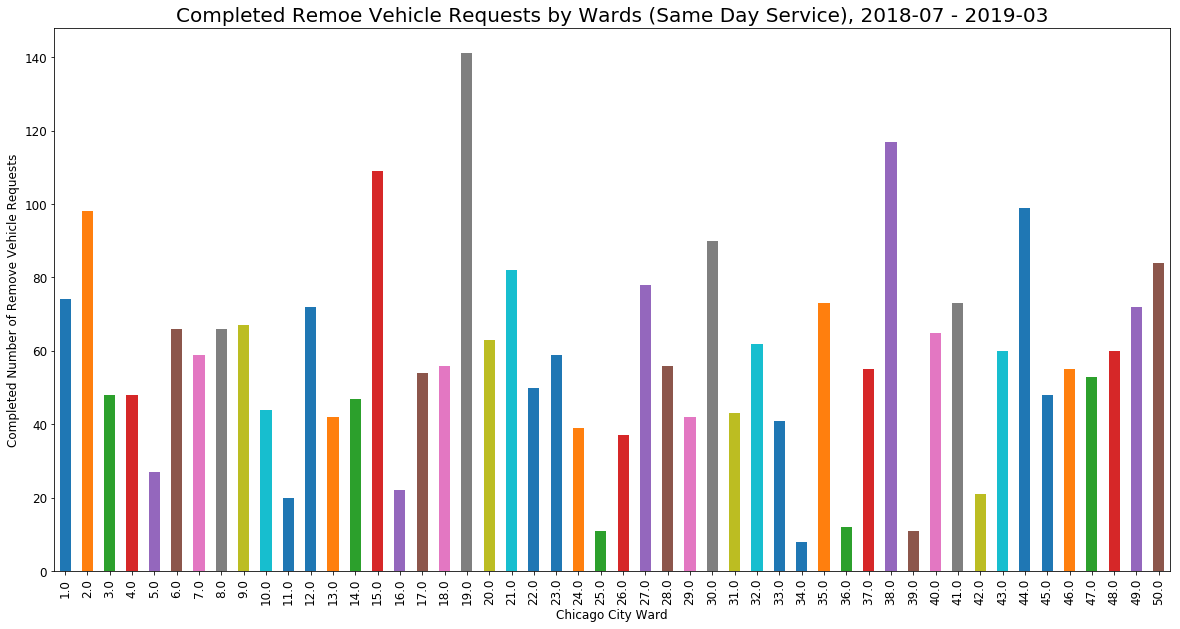

In [17]:
# Plot a bar chart for number of requests closed in same days by ward
# Group by ward
same_day_group = same_day.groupby("Wards")

# Count the number of requests by ward
ward_same_day_counts = same_day_group["Wards"].count()

# Plot in a bar chart
ward_same_chart = ward_same_day_counts.plot(kind='bar', figsize = (20,10), fontsize=12)

# Set the xlabel and ylabel using class methods
ward_same_chart.set_title("Completed Remoe Vehicle Requests by Wards (Same Day Service), 2018-07 - 2019-03", fontsize=20)
ward_same_chart.set_xlabel("Chicago City Ward", fontsize=12)
ward_same_chart.set_ylabel("Completed Number of Remove Vehicle Requests", fontsize=12)




In [14]:
# Plot the average time to close a request by ward using completion group

# Calculate the average time it took to close the request by ward
avg_days = round(car_summary_df["Days_Completion"].mean(),0)
#print(avg_days)


# Plot in a bar chart
avg_days_chart = avg_days.plot(kind='bar', figsize = (20,10), fontsize=12)

# Set the xlabel and ylabel using class methods
avg_days_chart.set_title("Average Number of Days to Remove Vehicle by Ward", fontsize=20)
avg_days_chart.set_xlabel("Chicago City Ward", fontsize=12)
avg_days_chart.set_ylabel("Number of Days", fontsize=12)



AttributeError: 'float' object has no attribute 'plot'